# Import Libraries
Source: https://www.kaggle.com/datasets/kukuroo3/body-performance-data

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from fastprogress import progress_bar
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier

In [2]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# set defult figuare settings
sns.set_theme(
    style='darkgrid',
    rc={"figure.figsize":(16, 9)}
)

In [4]:
# loading dataset
df = pd.read_csv('data/bodyPerformance.csv')
df.head()

,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class
0,27.0,M,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,C
1,25.0,M,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0,A
2,31.0,M,179.6,78.00,20.1,92.0,152.0,44.8,12.0,49.0,181.0,C
3,32.0,M,174.5,71.10,18.4,76.0,147.0,41.4,15.2,53.0,219.0,B
4,28.0,M,173.8,67.70,17.1,70.0,127.0,43.5,27.1,45.0,217.0,B


### Drop NA & One Hot Encoding

In [5]:
# drop na values
df.dropna(inplace=True)

# reset index
df.reset_index(inplace=True, drop=True)

# one-hot encoding
df = pd.get_dummies(df, columns=['gender'], drop_first=True)
df['gender_M'] = df['gender_M'].astype(np.int8)

### Class Distribution

<Axes: xlabel='class'>

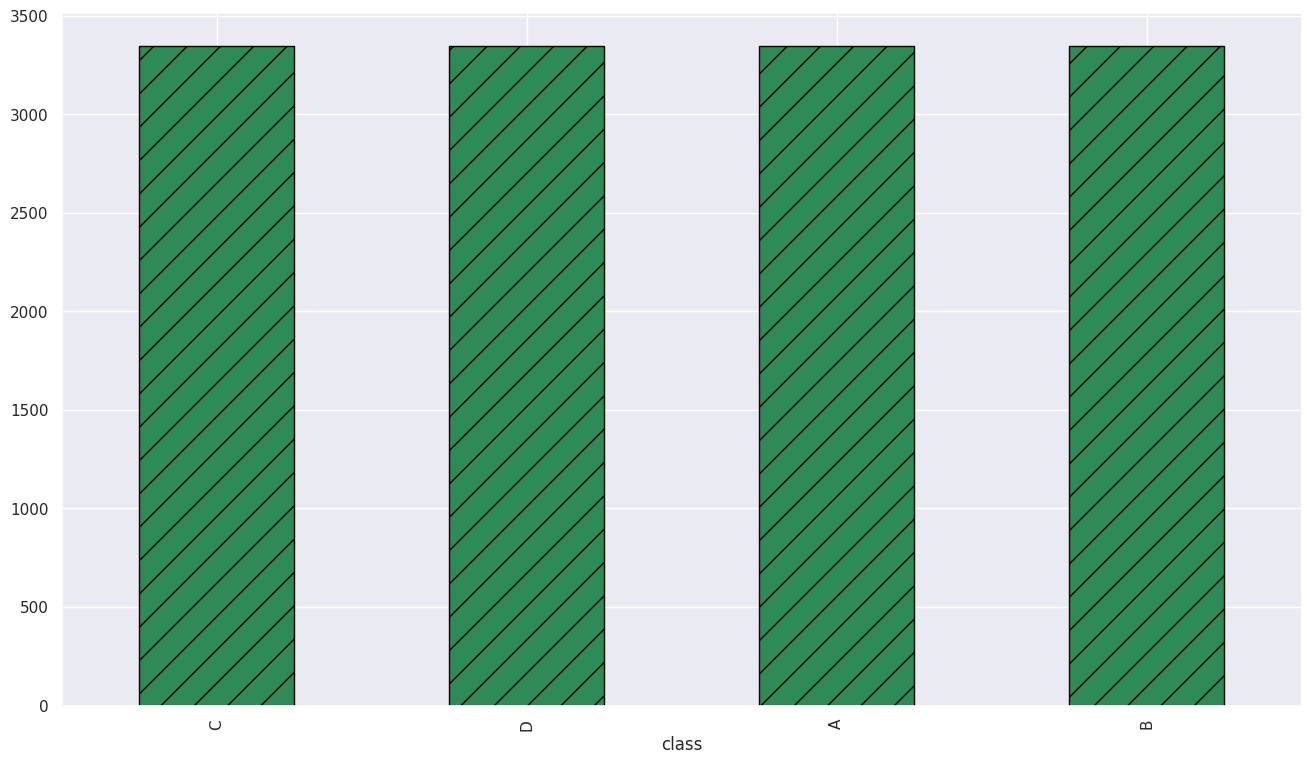

In [6]:
df['class'].value_counts().plot.bar(color='seagreen', hatch='/', edgecolor='black')

### Normalize

In [7]:
# scaling the data
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df.drop(['gender_M', 'class'], axis=1)),
                        columns=df.columns[:-2])

df_scaled[['gender_M', 'class']] = df[['gender_M', 'class']]

### PCA

In [8]:
# split into variables x and target y
x = df_scaled.drop(['class'], axis=1)
y = df_scaled['class']

In [9]:
x.sample(5)

,age,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,gender_M
11389,0.823837,0.028505,-0.648353,0.463006,-0.818948,-0.695612,-1.013122,1.216922,0.366259,-0.530009,0
11854,-0.130282,1.511961,0.933340,-0.253586,1.136062,0.459797,0.417538,0.743905,-0.054022,1.125515,1
1153,-0.790826,0.265858,0.062990,-1.066642,-2.401576,-1.918986,0.153996,0.909461,1.206821,2.254282,1
7765,0.089900,1.155932,0.983552,-0.143341,-0.074183,-0.491716,0.041049,-3.170308,-0.824537,-0.053419,1
6534,-0.864220,-1.490554,-1.886928,0.697276,-0.074183,-1.171368,-1.239015,-0.426811,0.366259,-0.730679,0


In [10]:
# apply PCA
pca = PCA()
x_pca = pd.DataFrame(pca.fit_transform(x),
                     columns=[f'PC{i}' for i in range(1, x.shape[1]+1)])

### Explained Variance

In [11]:
# number of PCs to obtain 90% of the original data
num_components = max(np.where(~(np.cumsum(pca.explained_variance_ratio_) >= 0.9))[0]) + 1
num_components

5

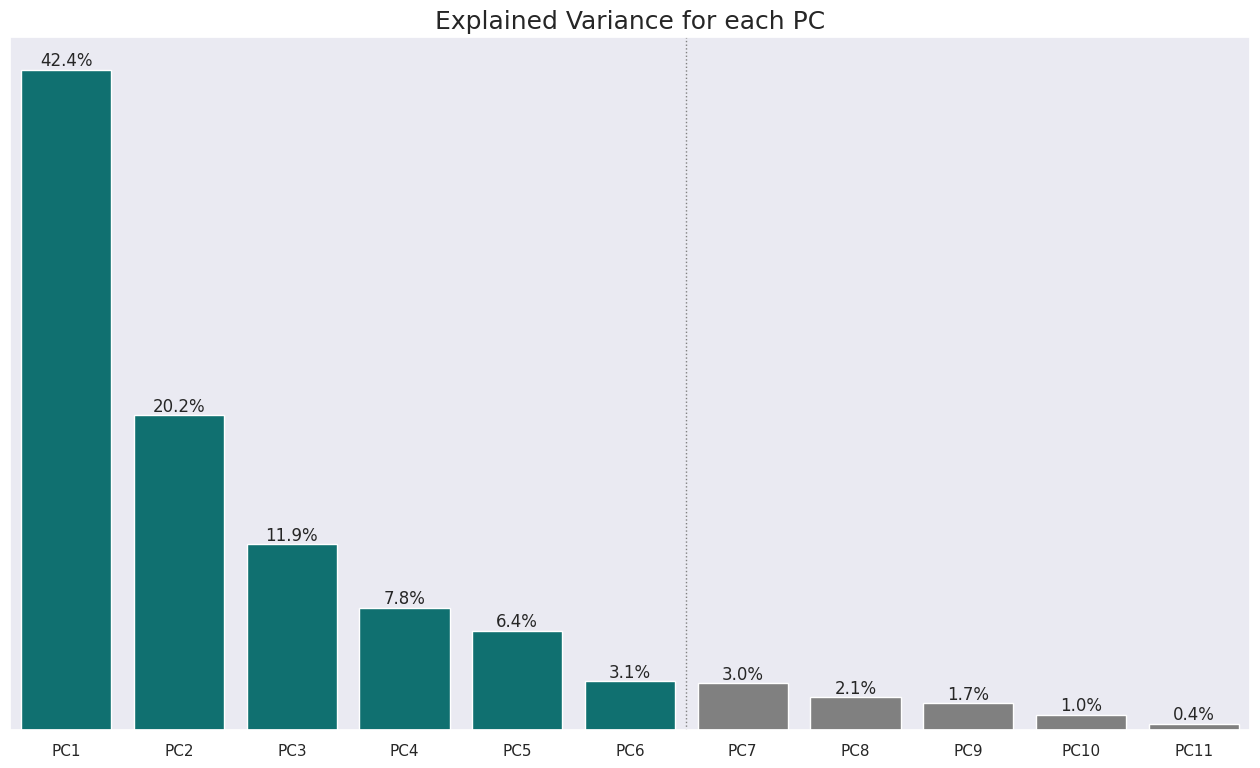

In [12]:
# plot explained variance ratio
ax = sns.barplot(x=x_pca.columns, y=pca.explained_variance_ratio_*100,
                palette=['teal' if i <= num_components else 'gray' for i in range(len(pca.explained_variance_ratio_))])
ax.bar_label(ax.containers[0], labels=[f'{round(i, 1)}%' for i in pca.explained_variance_ratio_*100])
plt.yticks([])
plt.axvline(num_components + 0.5, linestyle=':', linewidth=1, color='gray')
plt.title('Explained Variance for each PC', fontsize=18)
plt.show()

In [13]:
# calculate loadings
pca_loadings = pca.components_.T * (np.sqrt(pca.explained_variance_))
pca_loadings = pd.DataFrame(pca_loadings, columns=x_pca.columns, index=x.columns)

pca_loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11
age,0.406249,-0.558143,0.037912,-0.661776,0.194876,-0.058338,0.132274,0.124899,-0.090907,0.032291,-0.018563
height_cm,-0.863211,-0.093175,-0.246886,-0.015315,0.104817,0.262854,-0.231424,0.160774,-0.048658,0.152383,0.000521
weight_kg,-0.698792,-0.417310,-0.335821,0.173849,0.386726,-0.018747,0.003593,0.048660,-0.019776,-0.202894,-0.027783
body fat_%,0.673459,-0.354522,-0.185089,0.478614,0.310407,-0.133706,0.121315,-0.007604,-0.075750,0.148753,0.025367
diastolic,-0.224323,-0.718058,0.452988,0.218272,-0.204046,0.288034,0.236573,0.021637,0.009886,-0.013065,-0.002033
systolic,-0.302731,-0.736277,0.423821,0.060801,-0.123695,-0.266993,-0.308922,-0.027862,0.002699,0.013853,-0.003066
gripForce,-0.889371,-0.121334,-0.056016,-0.154334,0.176293,-0.070096,0.141440,-0.187751,0.256514,0.099891,-0.019746
sit and bend forward_cm,0.110171,0.401565,0.739331,-0.001842,0.512466,0.102299,-0.076777,-0.020223,0.003334,-0.012721,0.022495
sit-ups counts,-0.762481,0.398895,0.243516,0.124504,-0.067764,-0.235280,0.177149,0.304205,0.019641,0.022744,-0.002190
broad jump_cm,-0.894117,0.203842,0.097301,-0.037331,-0.034328,-0.055220,0.100268,-0.202700,-0.301915,0.029543,-0.028661


In [16]:
pca_loadings.iloc[:4, :4].round(3)

,PC1,PC2,PC3,PC4
age,0.406,-0.558,0.038,-0.662
height_cm,-0.863,-0.093,-0.247,-0.015
weight_kg,-0.699,-0.417,-0.336,0.174
body fat_%,0.673,-0.355,-0.185,0.479


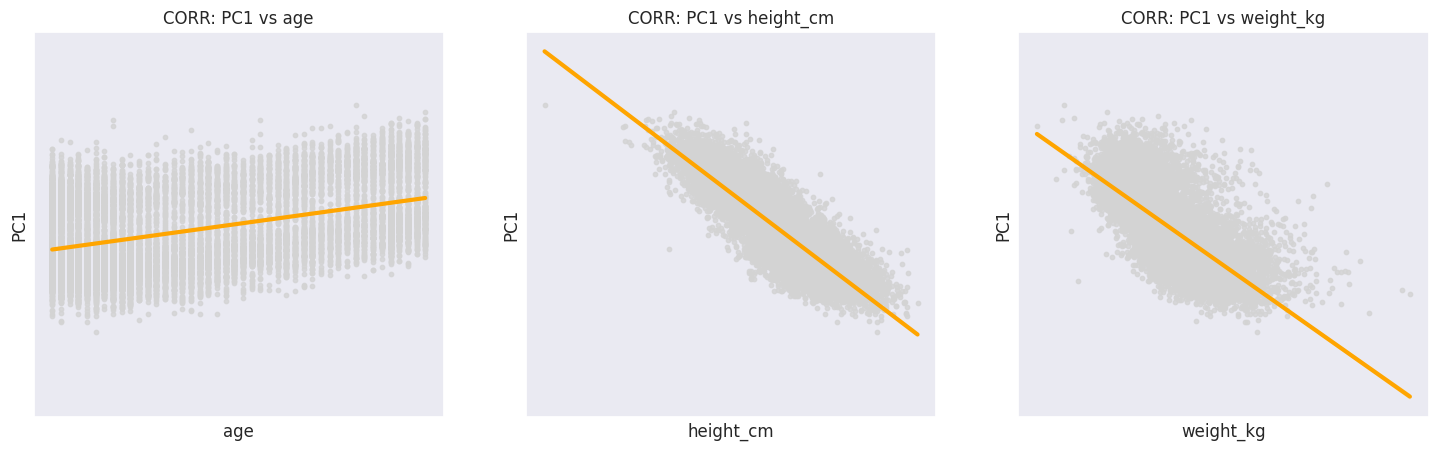

In [31]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

sns.regplot(x=x['age'], y=x_pca['PC1'],
            scatter_kws=dict(color='lightgray', s=10),
            line_kws=dict(linewidth=3, color='orange'),
            ax=ax[0])

sns.regplot(x=x['height_cm'], y=x_pca['PC1'],
            scatter_kws=dict(color='lightgray', s=10),
            line_kws=dict(linewidth=3, color='orange'),
            ax=ax[1])

sns.regplot(x=x['weight_kg'], y=x_pca['PC1'],
            scatter_kws=dict(color='lightgray', s=10),
            line_kws=dict(linewidth=3, color='orange'),
            ax=ax[2])
# disable x and y ticks
for a in ax: a.set_xticks([]), a.set_yticks([])

# add titles
ax[0].set_title('CORR: PC1 vs age')
ax[1].set_title('CORR: PC1 vs height_cm')
ax[2].set_title('CORR: PC1 vs weight_kg')

plt.show()

In [37]:
# sum of all coefficients regarding PC1 = ~1
np.square(pca.components_.T[1,:]).sum()

1.0000000000000002

In [15]:
# applying 0.2 threshold to loadings
(pca_loadings.iloc[:4, :4].round(3).abs() >= 0.2).astype('int')

,PC1,PC2,PC3,PC4
age,1,1,0,1
height_cm,1,0,1,0
weight_kg,1,1,1,0
body fat_%,1,1,0,1


### Split into train and test

In [124]:
# split sclaed data
x_train, x_test, y_train, y_test = train_test_split(x, y, shuffle=True, test_size=0.20, stratify=y)

# 
y_train = y_train.map({'A':0, 'B':1, 'C':2, 'D':3})
y_test = y_test.map({'A':0, 'B':1, 'C':2, 'D':3})

# get the same split for pca data
x_pca_train = x_pca.loc[x_train.index]
x_pca_test = x_pca.loc[x_test.index]

# assert all indecies for x and x_pca
assert np.all(x_train.index == x_pca_train.index)
assert np.all(x_test.index == x_pca_test.index)

### MLP Classifier

In [161]:
def fit_mlp_cls(x, y, x_test, y_test):
    "Train MLP model"
    cls = MLPClassifier(hidden_layer_sizes=[50, 50],
                        batch_size=x.shape[0],
                        shuffle=True,
                        max_iter=100,
                        early_stopping=True, n_iter_no_change=5)
    cls.fit(x, y)
    return cls, cls.n_iter_, cls.score(x, y), cls.score(x_test, y_test)

In [162]:
def calc_param_mlp(cls):
    "Calculate number of parameters for MLP model"
    params = 0
    
    for i in range(cls.n_layers_ - 3): # 3 input, output, last hidden layer
        params += cls.hidden_layer_sizes[i] * cls.hidden_layer_sizes[i+1]
        
    params += cls.n_features_in_ * cls.hidden_layer_sizes[0]
    params += cls.n_outputs_ * cls.hidden_layer_sizes[-1]
    
    params += sum(cls.hidden_layer_sizes) + cls.n_outputs_
    
    return params


def compare_params(new, old):
    return round((calc_param_mlp(new) - calc_param_mlp(old)) / calc_param_mlp(old), 4) * 100

In [175]:
# train MLP and gradually add columns
scores = {'all':[], 'pca':[]}

# run the model for 10 times
for i in progress_bar(range(1, x_pca_train.shape[1]+1)):
    
    x_train_temp = x_train.iloc[:, :i]
    x_test_temp = x_test.iloc[:, :i]
    
    x_pca_train_comp = x_pca_train.iloc[:, :i]
    x_pca_test_comp = x_pca_test.iloc[:, :i]
    
    scores['all'].append(fit_mlp_cls(x_train_temp, y_train, x_test_temp, y_test)[-1])
    scores['pca'].append(fit_mlp_cls(x_pca_train_comp, y_train, x_pca_test_comp, y_test)[-1])

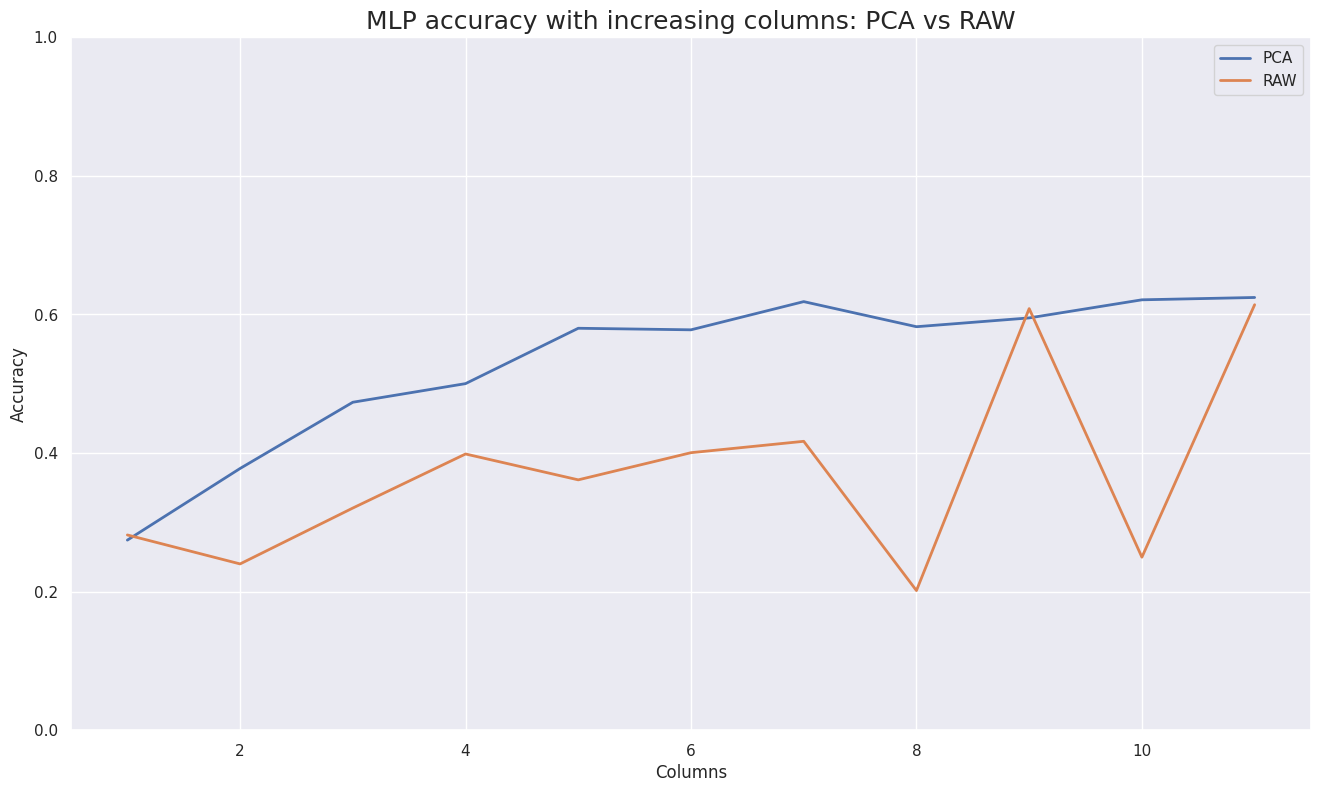

In [176]:
sns.lineplot(x=range(1, x_pca_train.shape[1]+1), y=scores['pca'], label='PCA', linewidth=2)
sns.lineplot(x=range(1, x_pca_train.shape[1]+1), y=scores['all'], label='RAW', linewidth=2)
plt.xlabel('Columns')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.title('MLP accuracy with increasing columns: PCA vs RAW', fontsize=18)
plt.show()

In [220]:
print(
    f"Best all accuracy: {np.max(scores['all'])*100:.2f}%",
    f"Only {num_components} components of PCA accuracy: {scores['pca'][num_components-1]*100:.2f}%",
    f"The Accuracy of all data vs only {num_components} components of PCA is: ~{(scores['pca'][num_components-1] - np.max(scores['all']))*100:.2f}%",
    sep='\n'
)

Best all accuracy: 61.40%
Only 5 components of PCA accuracy: 58.01%
The Accuracy of all data vs only 5 components of PCA is: ~-3.40%


In [156]:
def PCA(X , num_components):
     
    #Step-1
    X_meaned = X - np.mean(X , axis = 0)
     
    #Step-2
    cov_mat = np.cov(X_meaned , rowvar = False)
     
    #Step-3
    eigen_values , eigen_vectors = np.linalg.eigh(cov_mat)
     
    #Step-4
    sorted_index = np.argsort(eigen_values)[::-1]
    sorted_eigenvalue = eigen_values[sorted_index]
    sorted_eigenvectors = eigen_vectors[:,sorted_index]
     
    #Step-5
    eigenvector_subset = sorted_eigenvectors[:,0:num_components]
     
    #Step-6
    X_reduced = np.dot(eigenvector_subset.transpose() , X_meaned.transpose() ).transpose()
     
    return X_reduced